**2. Clasic ML Models**

Tuning and training classic ML models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score, classification_report,
    roc_auc_score, roc_curve)
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna

In [ ]:
# NaN Checking
df = pd.read_csv('clean_comments.csv')
print(df['clean'].isna().sum())
df = df.dropna(subset=['clean'])
print(df['clean'].isna().sum())

11
0


In [ ]:
# Vectorize
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)
X = vectorizer.fit_transform(df['clean'])
y = df['relevant']

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)

- Optuna (tuning)

In [ ]:
# Logistic Regression
def objective_lr(trial):
    c = trial.suggest_loguniform('C', 1e-4, 10)
    iter = trial.suggest_int('max_iter', 1000, 2000, step=200)
    model = LogisticRegression(C=c, max_iter=iter)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return f1_score(y_val, preds)

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

best_lr = LogisticRegression(**study_lr.best_params)
best_lr.fit(X_train, y_train)
y_pred_lr = best_lr.predict(X_test)

[I 2025-06-11 16:17:36,778] A new study created in memory with name: no-name-8aee382a-dc09-42c5-9a92-4f12301867a1
C:\Users\kpodd\AppData\Local\Temp\ipykernel_6576\4284430219.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1e-4, 10)
[I 2025-06-11 16:17:37,138] Trial 0 finished with value: 0.8297237315374608 and parameters: {'C': 7.40508504574748, 'max_iter': 1400}. Best is trial 0 with value: 0.8297237315374608.
C:\Users\kpodd\AppData\Local\Temp\ipykernel_6576\4284430219.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1e-4, 10)
[I 2025-06-11 16:17:37,159] Trial 1 finished with value: 0.8345265975

In [ ]:
# Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=5)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return f1_score(y_val, preds)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)

best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

[I 2025-06-11 16:19:27,924] A new study created in memory with name: no-name-3162c625-a410-460c-b7d1-74ed34d21b5e
[I 2025-06-11 16:19:29,767] Trial 0 finished with value: 0.8345265975242556 and parameters: {'n_estimators': 350, 'max_depth': 5}. Best is trial 0 with value: 0.8345265975242556.
[I 2025-06-11 16:19:34,193] Trial 1 finished with value: 0.8345265975242556 and parameters: {'n_estimators': 150, 'max_depth': 20}. Best is trial 0 with value: 0.8345265975242556.
[I 2025-06-11 16:19:34,474] Trial 2 finished with value: 0.8345265975242556 and parameters: {'n_estimators': 50, 'max_depth': 5}. Best is trial 0 with value: 0.8345265975242556.
[I 2025-06-11 16:19:40,058] Trial 3 finished with value: 0.8345265975242556 and parameters: {'n_estimators': 300, 'max_depth': 15}. Best is trial 0 with value: 0.8345265975242556.
[I 2025-06-11 16:19:43,245] Trial 4 finished with value: 0.8345265975242556 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 0 with value: 0.8345265

In [23]:
# CatBoost
def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 800, step=100),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'verbose': 0,
        'random_seed': 42
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return f1_score(y_val, preds)

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=5)

best_cb = CatBoostClassifier(**study_cb.best_params, verbose=100, random_state=42)
best_cb.fit(X_train, y_train)
y_pred_cb = best_cb.predict(X_test)

[I 2025-06-11 16:26:18,632] A new study created in memory with name: no-name-681c2bcf-4aef-4662-be44-75a4883cd287
[I 2025-06-11 16:29:45,594] Trial 0 finished with value: 0.8402610786671247 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.02676842730808082}. Best is trial 0 with value: 0.8402610786671247.
[I 2025-06-11 16:30:38,281] Trial 1 finished with value: 0.8424276169265034 and parameters: {'iterations': 600, 'depth': 5, 'learning_rate': 0.04861113604485205}. Best is trial 1 with value: 0.8424276169265034.
[I 2025-06-11 16:31:18,946] Trial 2 finished with value: 0.8401514048624253 and parameters: {'iterations': 700, 'depth': 4, 'learning_rate': 0.19955385217587226}. Best is trial 1 with value: 0.8424276169265034.
[I 2025-06-11 16:31:42,014] Trial 3 finished with value: 0.8415377074434564 and parameters: {'iterations': 400, 'depth': 4, 'learning_rate': 0.10562343047382008}. Best is trial 1 with value: 0.8424276169265034.
[I 2025-06-11 16:35:53,385] Trial 4 finish

0:	learn: 0.6788414	total: 444ms	remaining: 4m 26s
100:	learn: 0.5183151	total: 42.2s	remaining: 3m 28s
200:	learn: 0.4960386	total: 1m 24s	remaining: 2m 47s
300:	learn: 0.4785383	total: 2m 5s	remaining: 2m 4s
400:	learn: 0.4632126	total: 2m 46s	remaining: 1m 22s
500:	learn: 0.4501770	total: 3m 28s	remaining: 41.1s
599:	learn: 0.4381100	total: 4m 10s	remaining: 0us


- Evaluating models

In [27]:
#Metrics
def evaluate_model(y_true, y_pred, probs, model_name):
    print('\n', model_name)
    print(classification_report(y_true, y_pred, digits=3))
    print("F1:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, probs))

evaluate_model(y_test, y_pred_lr, best_lr.predict_proba(X_test)[:, 1], "Logistic Regression")
evaluate_model(y_test, y_pred_rf, best_rf.predict_proba(X_test)[:, 1], "Random Forest")
evaluate_model(y_test, y_pred_cb, best_cb.predict_proba(X_test)[:, 1], "CatBoost")


 Logistic Regression
              precision    recall  f1-score   support

           0      0.680     0.268     0.385      2473
           1      0.766     0.950     0.848      6236

    accuracy                          0.756      8709
   macro avg      0.723     0.609     0.617      8709
weighted avg      0.742     0.756     0.717      8709

F1: 0.8480813287514318
Precision: 0.7660372478013451
Recall: 0.949807568954458
ROC-AUC: 0.7943181809339456

 Random Forest
              precision    recall  f1-score   support

           0      1.000     0.002     0.003      2473
           1      0.716     1.000     0.835      6236

    accuracy                          0.717      8709
   macro avg      0.858     0.501     0.419      8709
weighted avg      0.797     0.717     0.599      8709

F1: 0.8347500167324811
Precision: 0.7163699023549684
Recall: 1.0
ROC-AUC: 0.7719144178552355

 CatBoost
              precision    recall  f1-score   support

           0      0.667     0.227     0.33

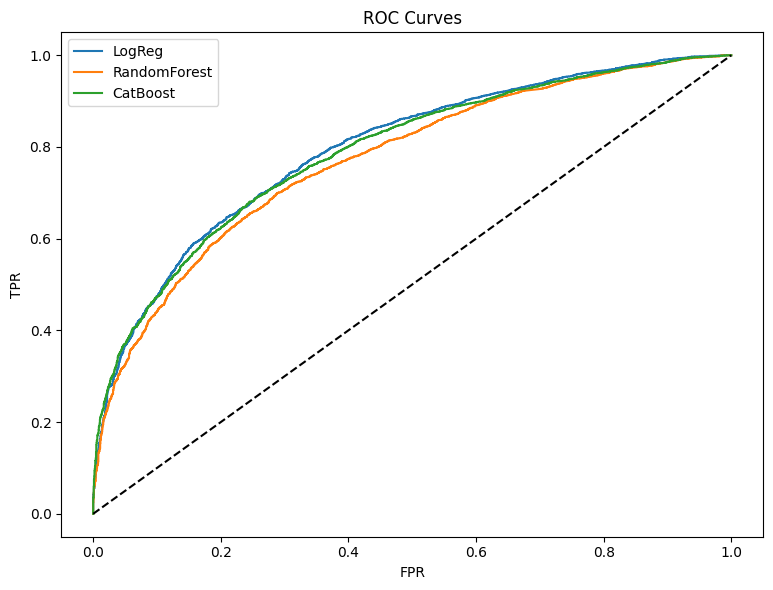

In [25]:
#ROC-Curve funtion
def plot_roc(models, names):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    for model, name in zip(models, names):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(
    [best_lr, best_rf, best_cb],
    ["LogReg", "RandomForest", "CatBoost"]
)

The aim of the project - identify and remove **all irrelevant** reviews, in order to ensure that the analytics are accurate and reliable.

That's why **recall** is very iportant metric for us.

Focusing on recall, the best is Random Forest Classifier, but it remove nearly 30% of relevant omments by mistake.

It's ok for us, because this is in line with the goals of the project.

The duration of the training should also be taken into attention. Logistic regression has learned much faster than other models. Random Forest has a balance. Сatboost training takes too much time.

In conclusion, the best classic model for our project is **Random Forest Classifier**.